In [2]:
import warnings
from typing import Optional, Sequence
import numpy as np
import os
import pandas as pd
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import datetime
import importlib
import math

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchmetrics.functional import pairwise_cosine_similarity
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

import lightly
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss

from avalanche.training.plugins import SupervisedPlugin
from avalanche.training.templates.supervised import SupervisedTemplate
from avalanche.training.plugins.evaluation import default_evaluator
from avalanche.models.dynamic_modules import MultiTaskModule
from avalanche.models import FeatureExtractorBackbone
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    loss_metrics,
    forgetting_metrics,
    confusion_matrix_metrics,
)
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

from datasets.coil100 import Coil100Dataset
from self_supervision.ssl import BarlowTwins, SimSiam
import clp.clp
from clp.clp import CLP


In [3]:
importlib.reload(clp.clp)
from clp.clp import CLP

root_dir = '/home/ehajizad/ss_learning/neuromorphic-continual-learning'
dataset_dir = '/home/ehajizad/ss_learning/ssl_tests/datasets/coil-100'

model_name = "coil100_simsiam_resnet9"
obj_list = [5, 7, 4, 18, 22, 26, 68, 75, 90, 99]
n_classes = len(obj_list)
test_size = 0.4
train_size = 1 - test_size

train_ds = Coil100Dataset(root_dir=dataset_dir, obj_list = obj_list,
                          transform=transforms.ToTensor(), size=64,
                          train=True, test_size=test_size)
test_ds = Coil100Dataset(root_dir=dataset_dir, obj_list = obj_list,
                         transform=transforms.ToTensor(), size=64,
                         train=False, test_size=test_size)

coil100_nc_bm = nc_benchmark(
        train_ds, test_ds, n_experiences=n_classes, shuffle=False,
        task_labels=False,
)


device = "cuda" if torch.cuda.is_available() else "cpu"

resnet = lightly.models.ResNetGenerator('resnet-9')
model = nn.Sequential(*list(resnet.children())[:-1],
                         nn.AdaptiveAvgPool2d(2))

# backbone = CoilCNNBackbone(in_channels = 3)

# simpleCNN = SimpleCNN()
# backbone = nn.Sequential(*list(simpleCNN.children())[:-1][0][:-2],
# nn.AdaptiveAvgPool2d(2))

model = model.to(device)
model.eval()
model.load_state_dict(torch.load(
        root_dir+"/models/"+model_name+".pth",
        map_location=device))
# model = nn.Sequential(*list(model.backbone), nn.Flatten())

model = model[0:-1] # take final conv layer, throw away the the last pooling layer

# embeddings = np.load(
#         root_dir+"/embeddings/coil100_bt_resnet_embeddings.npz")
# X = torch.from_numpy(embeddings["X"])
# y = torch.from_numpy(embeddings["y"])

# Generate embedding

feat_ext_dl = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=4)

embeddings = []
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = model(image).flatten(start_dim=1)
        embeddings.append(emb)

embeddings = torch.cat(embeddings, 0)
# feature_size = 32768

alpha_start_list = [0.6]
alpha_error_list = [0.01]
tau_alpha_decay_list = [3]
tau_alpha_growth_list = [9]
sim_th_list = [10000]
w_max = 5
w_min = 0

for alpha_start in alpha_start_list:
    for alpha_error in alpha_error_list:
        for tau_alpha_decay in tau_alpha_decay_list:
            for tau_alpha_growth in tau_alpha_growth_list:
                for sim_th in sim_th_list:

                    log_dir = "logs/cars10/" +  "dp_sparse_" + "_sim_th=" +str(sim_th) +"_a+="+str(alpha_start) + \
                    "_a-=" + str(alpha_error) + "_tau_dc=" + str(tau_alpha_decay) + "_tau_gr=" + str(tau_alpha_growth) + \
                    "__" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

                    eval_plugin = EvaluationPlugin(
                            accuracy_metrics(experience=True, stream=True),
                            forgetting_metrics(experience=True, stream=True),
                            confusion_matrix_metrics(num_classes=n_classes, save_image=False, stream=True),
                            loggers=[TensorboardLogger(log_dir)],
                    )

                    # CREATE THE STRATEGY INSTANCEi

                    clvq = CLP(clvq_model=model,
                               n_protos=1000,
                               bmu_metric="dot_product",
                               criterion=None,
                               alpha_start=alpha_start,
                               alpha_error=alpha_error,
                               tau_alpha_decay=tau_alpha_decay,
                               tau_alpha_growth=tau_alpha_growth,
                               sim_th=sim_th,
                               w_max=w_max,
                               w_min=w_min,
                               max_allowed_mistakes=1,
                               input_size=embeddings.shape[1],
                               num_classes=n_classes,
                               eval_mb_size=math.ceil(72*test_size),
                               train_mb_size=math.ceil(72*train_size),
                               train_epochs=1,
                               device=device,
                               evaluator=eval_plugin)

                    clvq.init_prototypes_from_data(embeddings)

                    # TRAINING LOOP
                    n_loops = 1
                    print("Starting experiment...")
                    for loop in range(1,n_loops+1):
                        for i, exp in enumerate(coil100_nc_bm.train_stream):

                            # fit SLDA model to batch (one sample at a time)
                            clvq.train(exp)

                            # evaluate model on test data
                            clvq.eval(coil100_nc_bm.test_stream[:min(loop*(i+1),n_classes)])


100%|██████████| 7200/7200 [00:00<00:00, 444894.43it/s]
/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/avalanche/training/plugins/evaluation.py:81: UserWarning: No benchmark provided to the evaluation plugin. Metrics may be computed on inconsistent portion of streams, use at your own risk.
  warnings.warn(


Starting experiment...


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/avalanche/training/plugins/evaluation.py:228: UserWarning: Evaluation stream is not equal to the complete test stream. This may result in inconsistent metrics. Use at your own risk.
  warnings.warn(msgw)


1.0


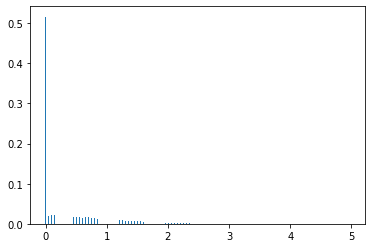

In [4]:
num_bins = 100
x = embeddings.cpu()[190,:]
x[np.absolute(x)<0.02]=0

counts, bins = np.histogram(x, bins=num_bins)
bins = bins[:-1]
probs = counts/float(counts.sum())
print (probs.sum()) # 1.0
plt.bar(bins, probs, 1.0/num_bins)
plt.show()

In [5]:
init_protos = np.random.choice(bins, size=(1000, embeddings.shape[1]), replace=True, p=probs)

In [7]:
init_protos.shape

(1000, 32768)

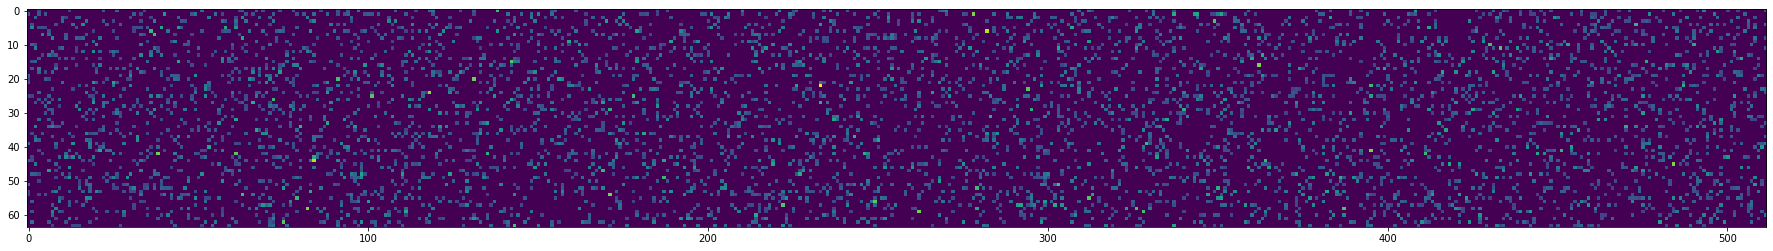

In [43]:
plt.figure(figsize=(32,4))
p = np.reshape(init_protos[0,:],(64,512), order='F')
p[np.absolute(p)<1]=0
plt.imshow(p)
plt.show()

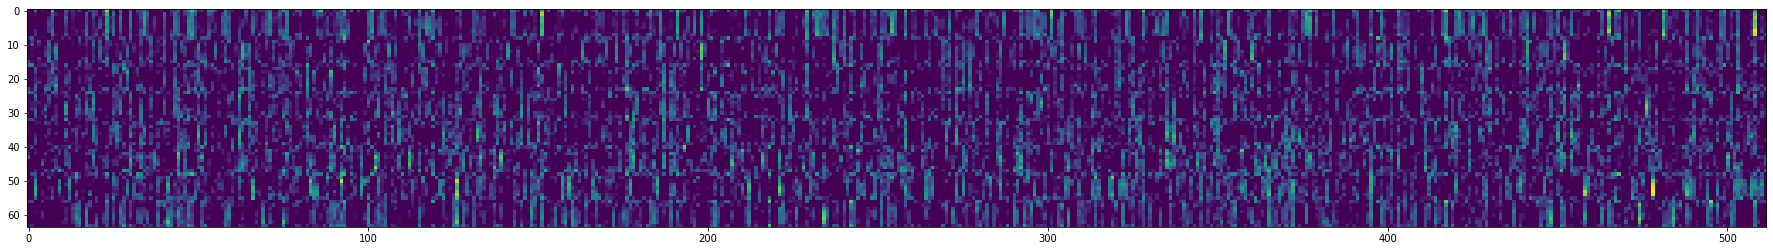

In [304]:
plt.figure(figsize=(34,4))
features = embeddings.cpu()
x = np.reshape(features[0,:],(64,512), order='F')
# x[np.absolute(x)<1]=0
plt.imshow(x)
plt.show()

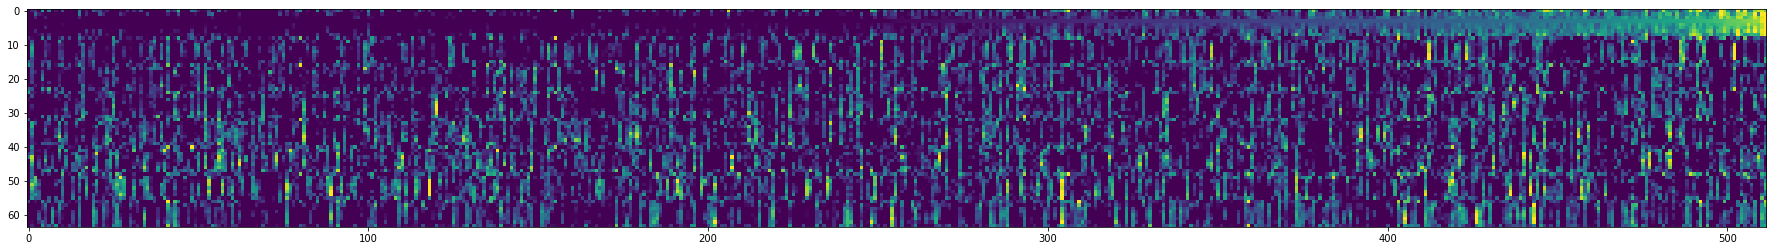

In [305]:
x=x[:,np.argsort(x[3,:])]
plt.figure(figsize=(34,4))
# x[np.absolute(x)<1]=0
plt.imshow(x, vmin=0, vmax=3)
plt.show()

1.0


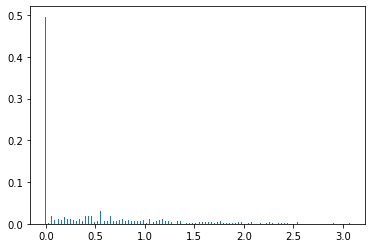

In [333]:
num_bins = 100
# x = embeddings.cpu()[190,:]
# x[np.absolute(x)<0.02]=0

counts, bins = np.histogram(x[3,:], bins=num_bins)
bins = bins[:-1]
probs = counts/float(counts.sum())
print (probs.sum()) # 1.0
plt.bar(bins, probs, 1.0/num_bins)
plt.show()
init_protos = np.random.choice(bins, size=(1000, embeddings.shape[1]), replace=True, p=probs)

In [334]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
n_proto = 2000
proto = np.zeros((n_proto, 64,512))
mu = 512*np.random.rand(n_proto,8)
sigma = 50
x = np.linspace(0, 512, 512)
for j in range(n_proto):
    for i in range(8):
        # a = 2.5*gaussian(x, mu[j,i], sigma)
        a = np.random.choice(bins, size=(512,), replace=True, p=probs)
        # np.random.shuffle(a)
        proto[j, i*8:(i+1)*8,:] = np.tile(a,(8,1))


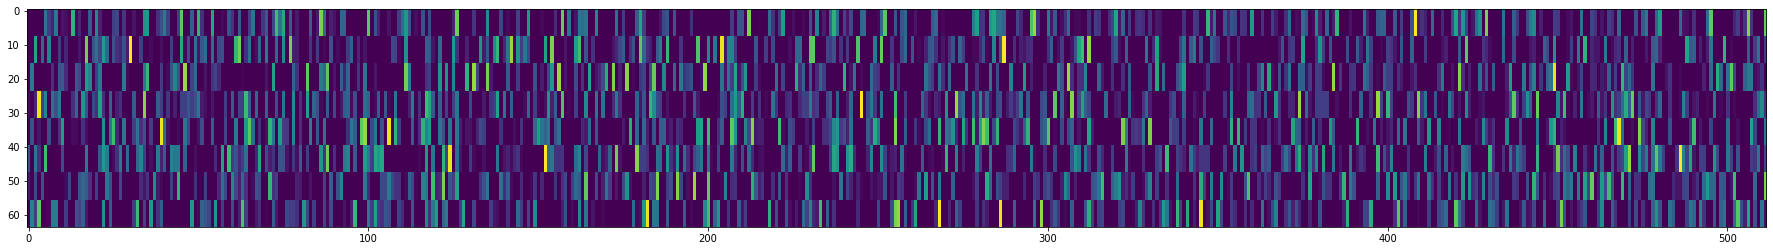

In [335]:
plt.figure(figsize=(34,4))
# x[np.absolute(x)<1]=0
plt.imshow(proto[0,:,:], vmin=0, vmax=3)
plt.show()

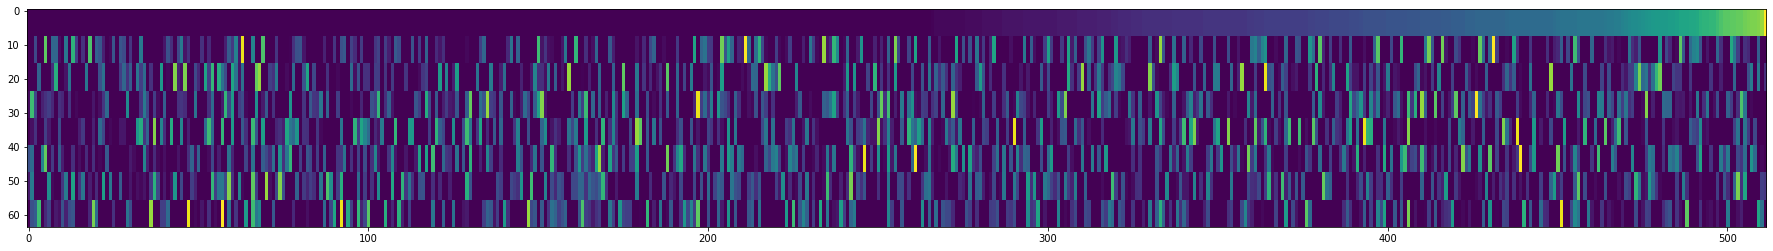

In [336]:
a_proto = proto[0,:,:].squeeze()
proto_sorted=a_proto[:,np.argsort(a_proto[3,:])]
plt.figure(figsize=(34,4))
# x[np.absolute(x)<1]=0
plt.imshow(proto_sorted, vmin=0, vmax=3)
plt.show()

(array([[27.,  3.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
          2.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
          0.,  2.,  0.,  1.,  4.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,
          0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [29.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
          1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  2.,  1.,  2.,
          1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  1.,  2.,
          1.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.

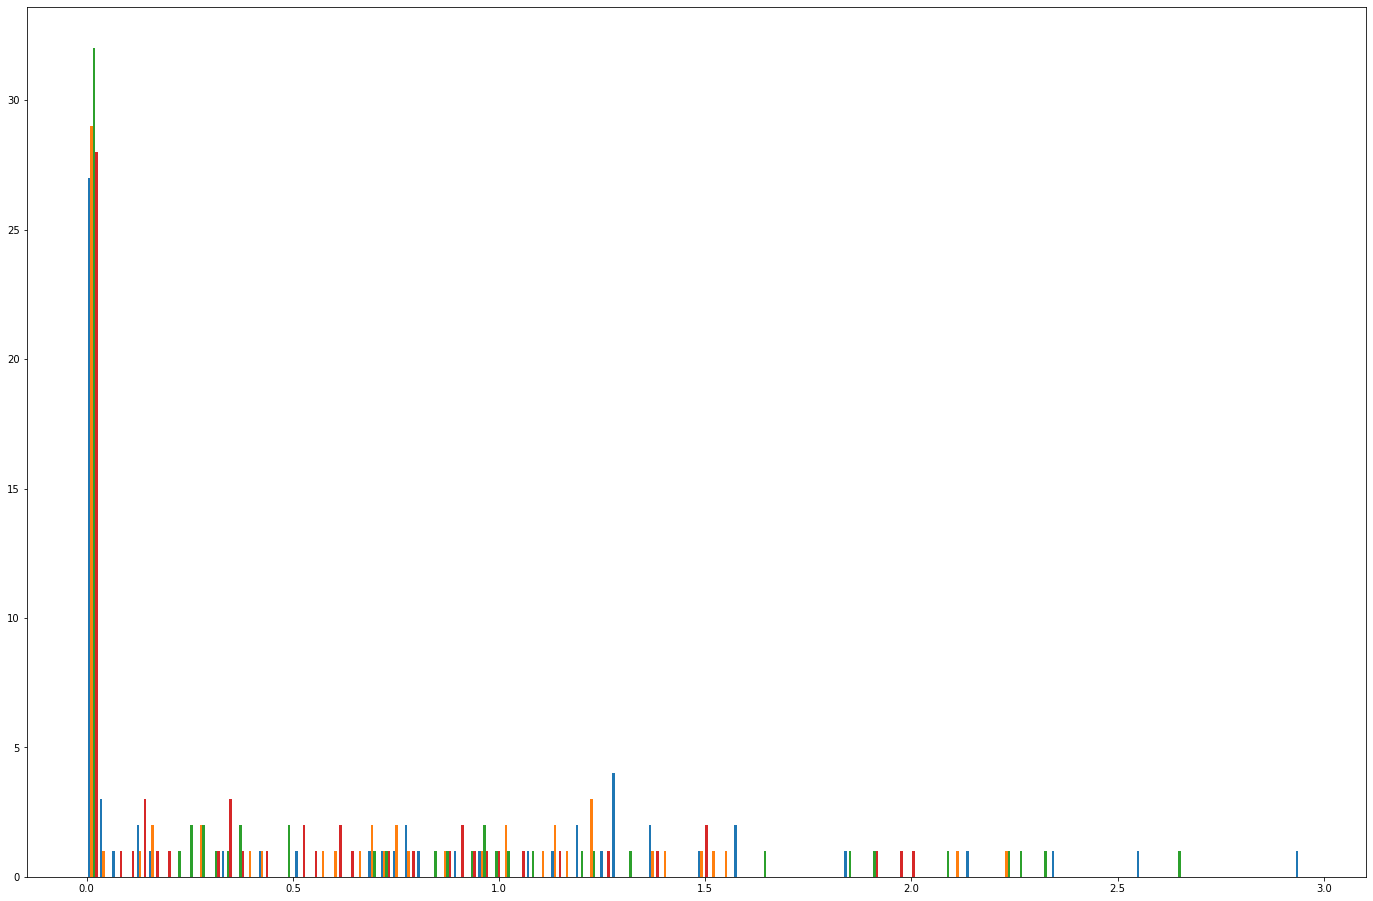

In [95]:
plt.figure(figsize=(24,16))
plt.hist(x[0:4,:], 100)

In [293]:
protos_tensor = torch.tensor(proto.reshape(1000,32768))
embeddings=embeddings.double()

In [294]:
embeddings = embeddings.to(device)
protos_tensor = protos_tensor.to(device)

In [295]:
sims = torch.matmul(protos_tensor, embeddings.T)

In [296]:
sims = sims.to('cpu')

In [297]:
sims.shape

torch.Size([1000, 6480])

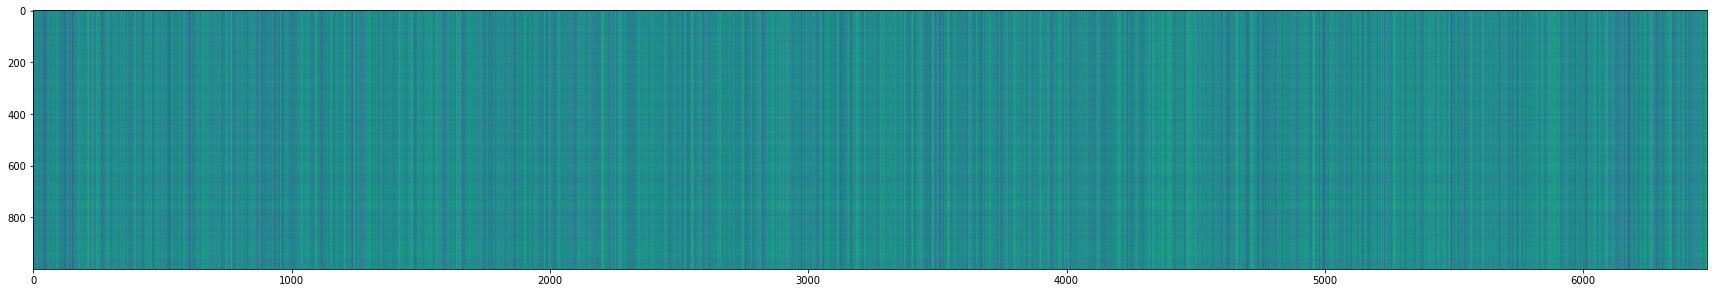

In [298]:
plt.figure(figsize=(30,10))
plt.imshow(sims)
plt.show()

In [7]:
results = clvq.eval(coil100_nc_bm.test_stream)

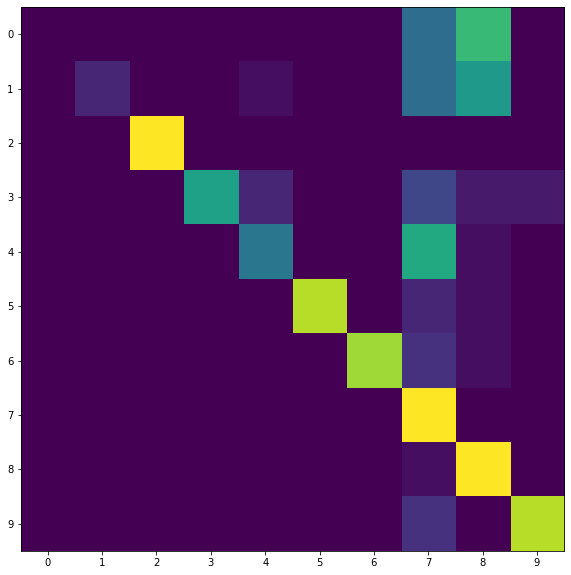

In [ ]:
plt.figure(figsize=(24,24))
cm = results["ConfusionMatrix_Stream/eval_phase/test_stream"]
plt.imshow(cm)
plt.xticks(np.arange(n_classes))
plt.yticks(np.arange(n_classes))
# plt.grid()
plt.show()

In [245]:
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
len(alloc_protos)

608

In [338]:
init_protos = np.reshape(proto,(n_proto,32768))

In [339]:
n_classes = 100

train_ds = Coil100Dataset(root_dir=dataset_dir, obj_list = np.arange(100),
                          transform=transforms.ToTensor(), size=64,
                          train=True, test_size=0.1)

feat_ext_dl = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=4)

embeddings = []
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = model(image).flatten(start_dim=1)
        embeddings.append(emb)

embeddings = torch.cat(embeddings, 0)

100%|██████████| 7200/7200 [00:00<00:00, 436609.78it/s]


In [340]:
from sklearn.decomposition import PCA


# simSiam_con_emb = np.load('simSiam_con_emb.npz') 
# features = simSiam_con_emb['X'][:n_classes*72,:]
# all_targets = simSiam_con_emb['y'][:n_classes*72]
features = embeddings.cpu()
all_targets = train_ds.targets
alloc_protos = init_protos
# alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
emb_and_protos = np.concatenate((features,alloc_protos), 0)

pca = PCA(n_components=1000)
pca_result = pca.fit_transform(emb_and_protos)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.7856568521112423


In [341]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=10, n_iter=500).fit_transform(pca_result)

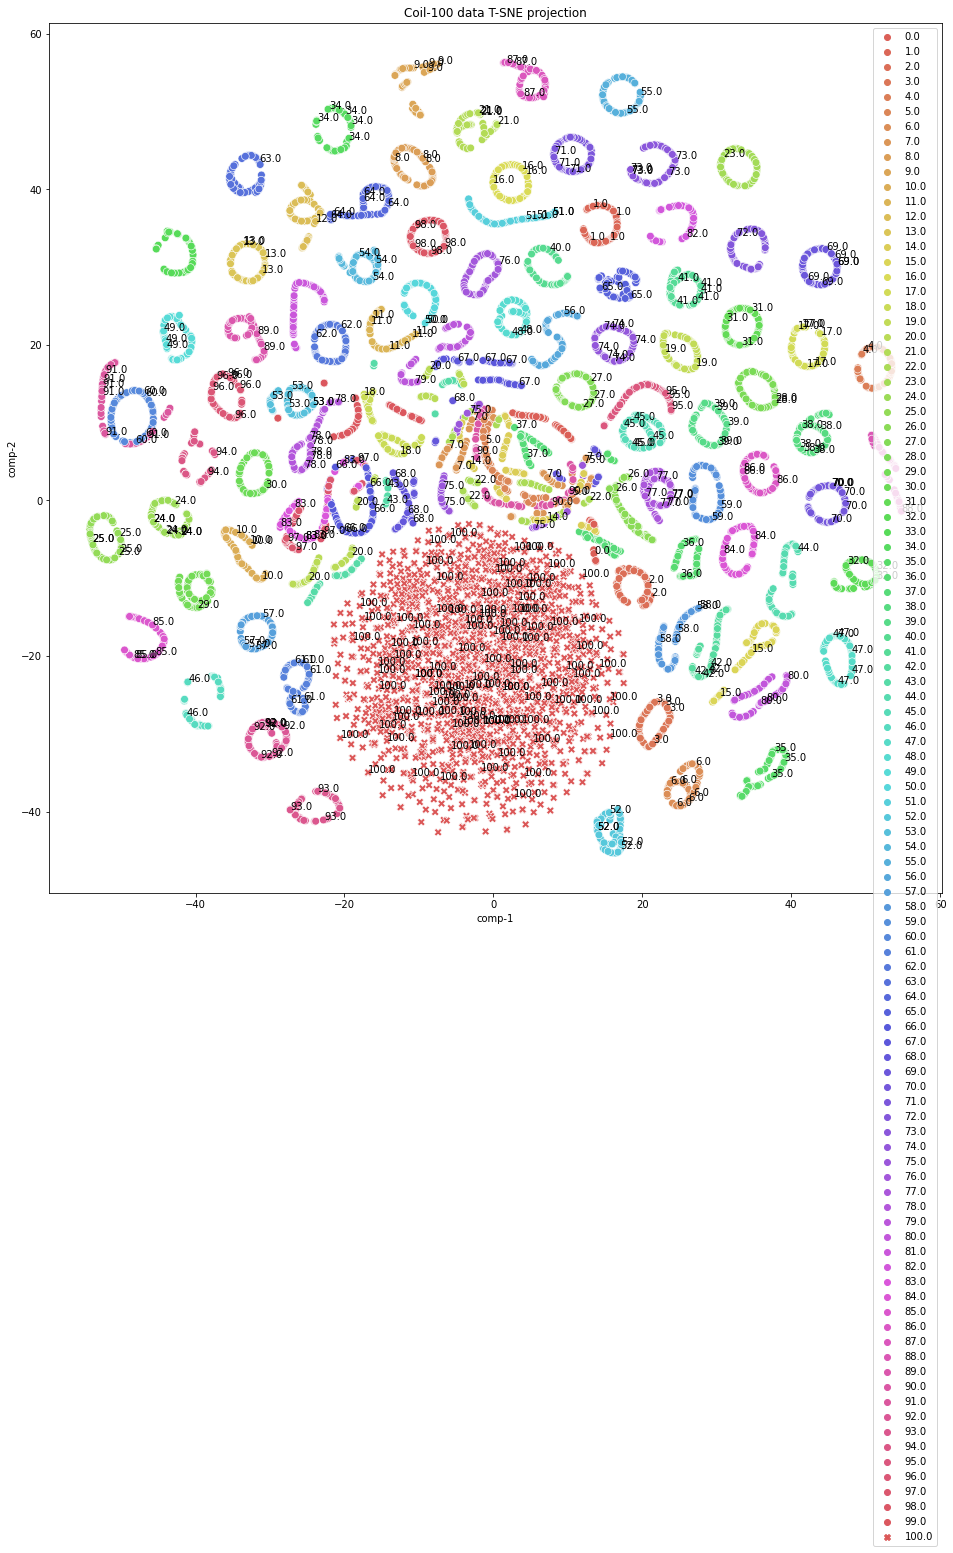

In [342]:
import seaborn as sns
y = np.concatenate((all_targets, n_classes*np.ones((len(alloc_protos),))))
proto_label = y.copy()
proto_label[proto_label<n_classes] = 0
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]
plt.figure(figsize=(16,16))
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), style=proto_label, s=60,
                    palette=sns.color_palette("hls", 101), legend=True,
                    data=df)

ax.set(title="Coil-100 data T-SNE projection") 

a = pd.concat({'x': df["comp-1"], 'y': df["comp-2"], 'label': df["y"]}, axis=1)
a = a.sample(frac=0.05, replace=True, random_state=1)
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], str(point['label']))

In [ ]:
torch.min(clvq.prototypes)

In [ ]:
for i, exp in enumerate(coil100_nc_bm.train_stream):
    print(exp.classes_in_this_experience)

In [ ]:
results=clvq.eval(coil100_nc_bm.test_stream)

In [ ]:
with open('clp_cosine.pkl', 'wb') as f:
    pickle.dump(results, f)
        
# with open('clp_cosine.pkl', 'rb') as f:
#     results = pickle.load(f)

In [ ]:
plt.figure(figsize=(16,16))
cm = results["ConfusionMatrix_Stream/eval_phase/test_stream"]
plt.imshow(cm)
results["Top1_Acc_Stream/eval_phase/test_stream/Task000"]

In [30]:
%load_ext tensorboard
%reload_ext tensorboard

In [31]:
%tensorboard --logdir 'logs/cars10/' --port 6006